## Import libs

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import PIL.ImageDraw
from PIL import ImageDraw

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Download graph

In [3]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

Unzip graph

In [4]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

Load graph into progarm

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:
label_map = []
categories = []
category_index = [] 

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Images input 

In [8]:
im1_path = '14.png'
im2_path = '11.png' 

PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, im1_path), 
                    os.path.join(PATH_TO_TEST_IMAGES_DIR, im2_path)]

# Size, in inches, of the output images.
IMAGE_SIZE = (24, 16)

In [9]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # write to temp for Tensorbaord --logdir /tmp/log/
      writer = tf.summary.FileWriter("/tmp/log/...", sess.graph)
        # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
      
    
      tf.image.draw_bounding_boxes(
        image,
        output_dict['detection_boxes'][0],
        name=None
            )

    
  return output_dict

In [10]:
def draw_da_box(image, boxes, score): 
    # list of boxes has the form [y_min, x_min, y_max, x_max]
    width, height = image.size
    draw = ImageDraw.Draw(image)
    
    
    for i in range(0, len(boxes)):
        if score[i] >=0.65 : 
            ref=boxes[i,:]

            ref = [ ref[1]*width, ref[0]*height, ref[3]*width,ref[2]*height]

            draw.rectangle(ref,outline = "Yellow")
    
    return image
    

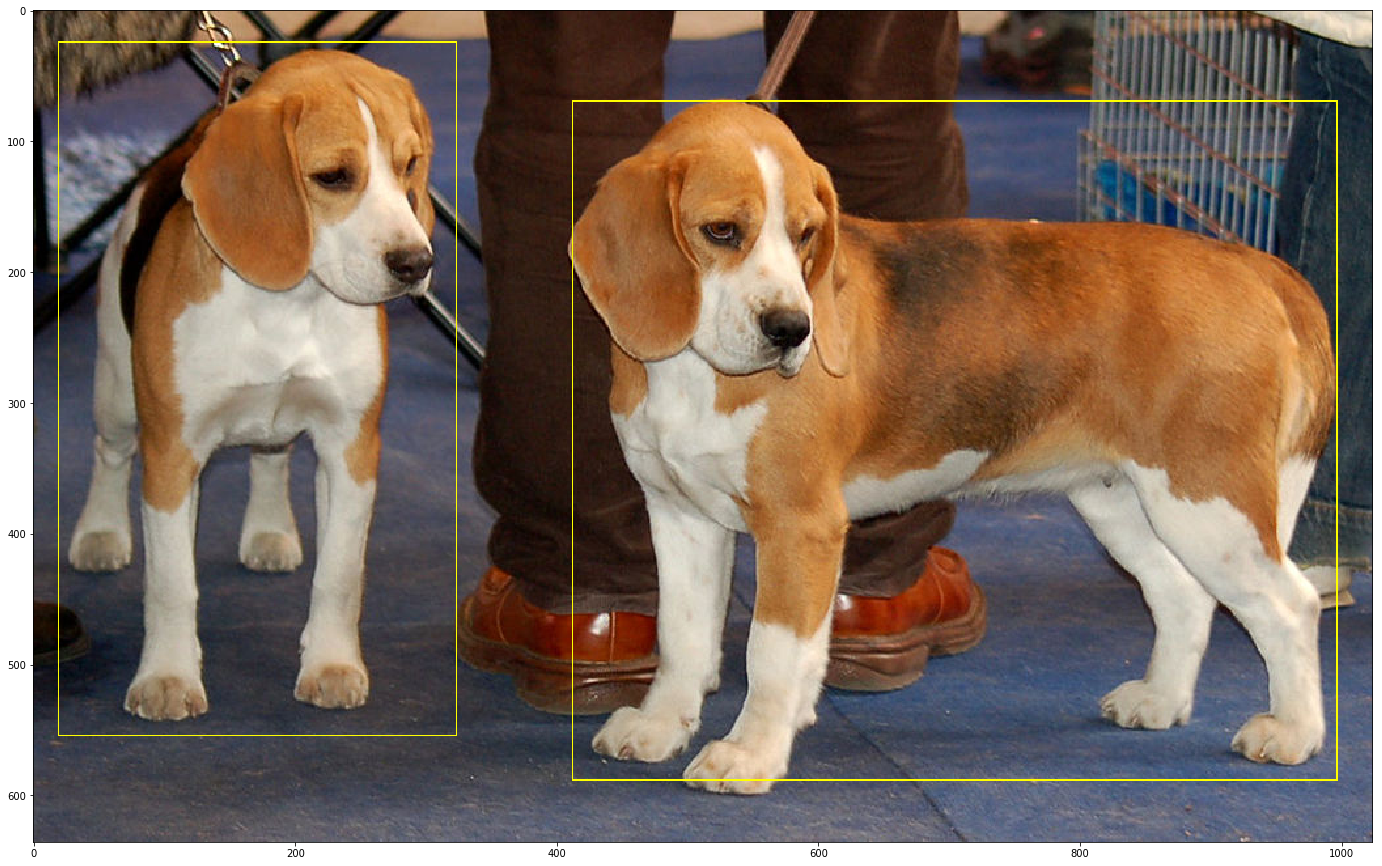

In [11]:
image = Image.open( os.path.join(PATH_TO_TEST_IMAGES_DIR, "image1.jpg"))
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
output_dict = run_inference_for_single_image(image_np, detection_graph)


imnew = draw_da_box(image,output_dict['detection_boxes'],output_dict['detection_scores'])
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)

In [12]:
def png_load_image_into_numpy_array(image):
    imdata = image.getdata()
#     print(image.size)
    (im_width, im_height) = image.size
    
    n_im =np.array(imdata).reshape((im_height, im_width)).astype(np.uint8)
    
    arr3D = np.tile(n_im[...,None],3)
#     print(arr3D.shape)
#     print(n_im.shape)
    
    return arr3D 

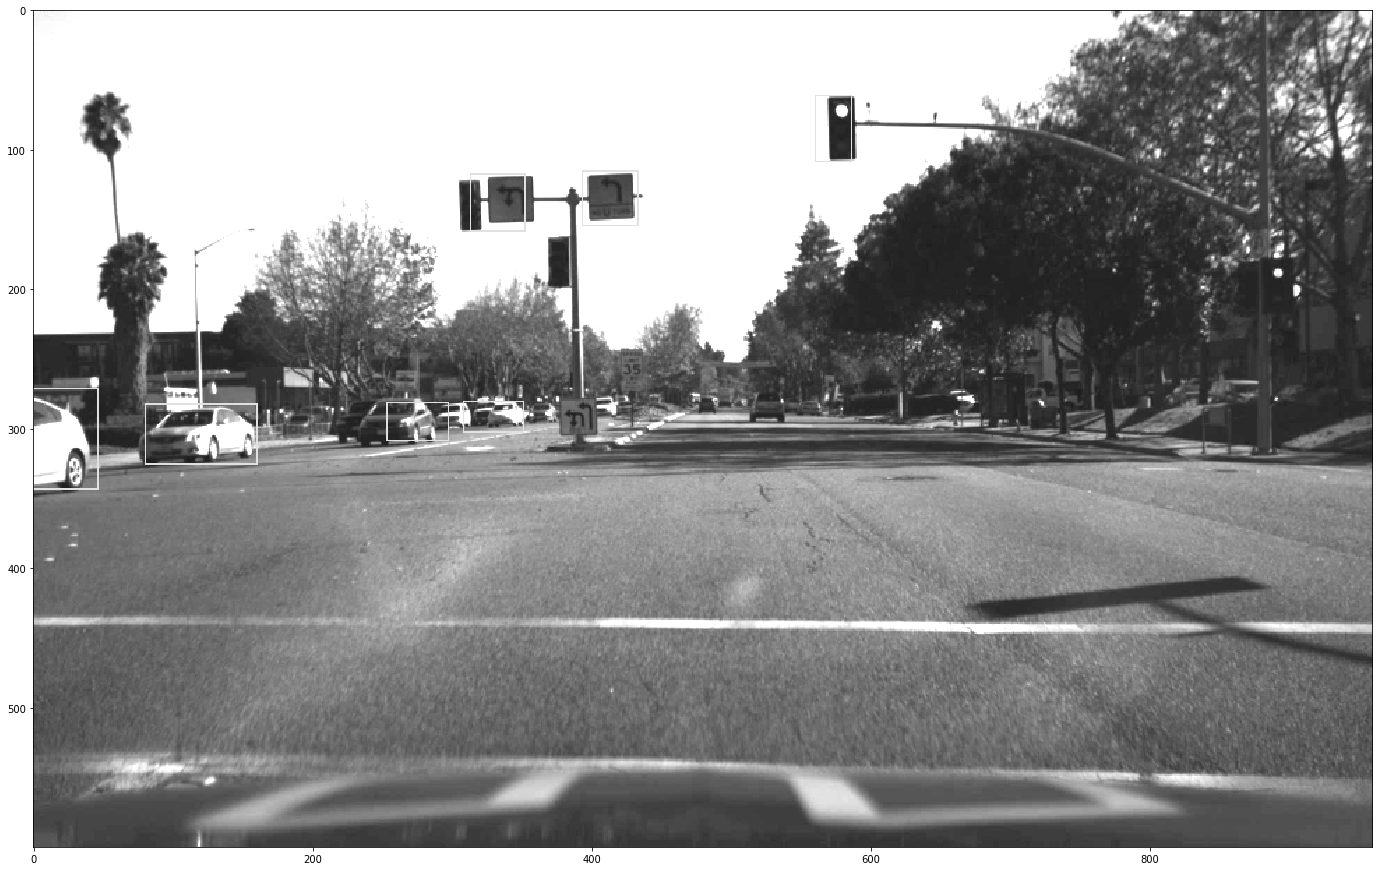

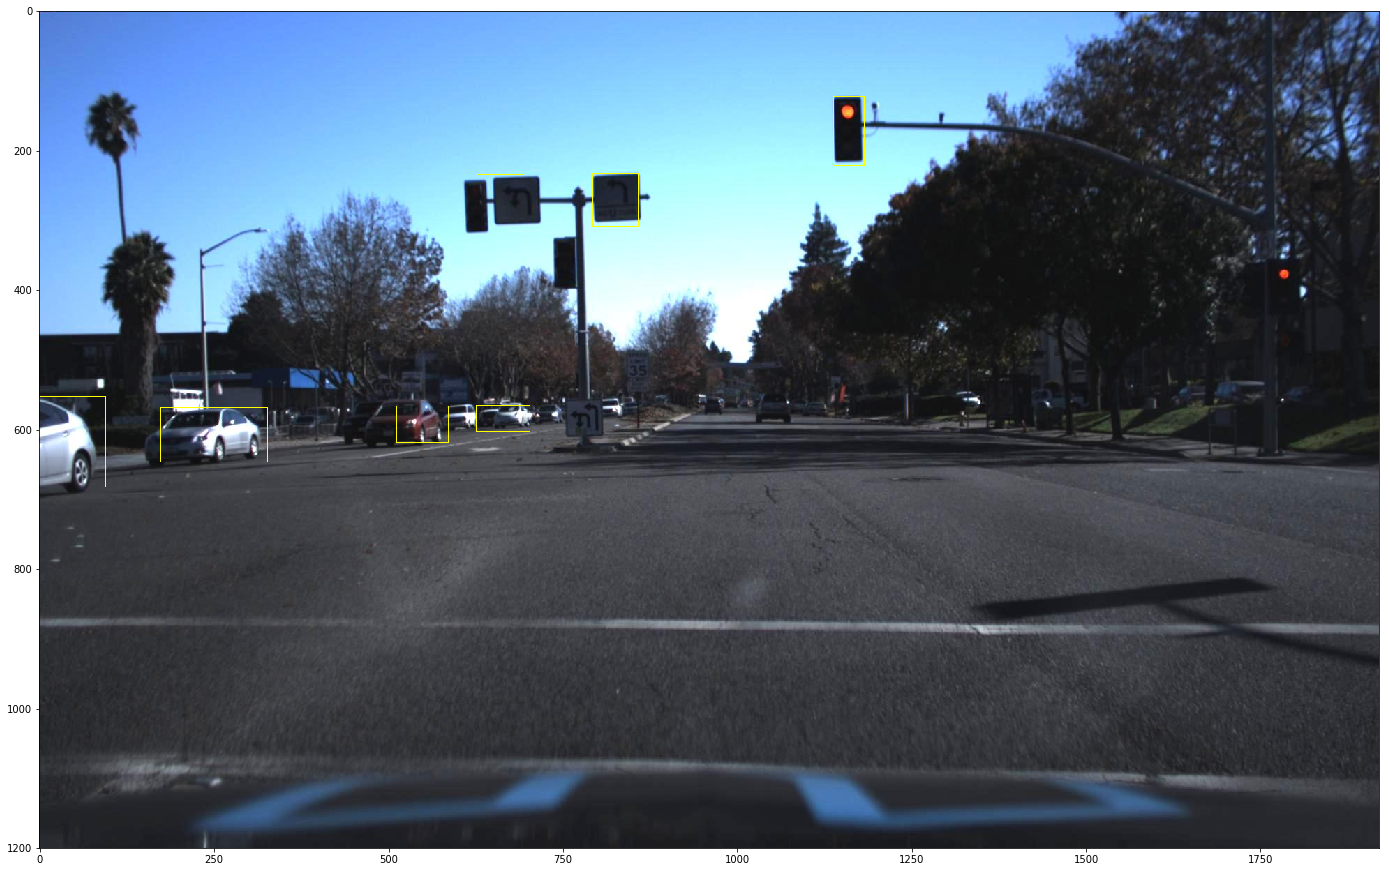

In [13]:
image = Image.open( os.path.join(PATH_TO_TEST_IMAGES_DIR, "83.png"))
image_np = png_load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
output_dict = run_inference_for_single_image(image_np, detection_graph)
image2 = Image.open( os.path.join(PATH_TO_TEST_IMAGES_DIR, "v183.jpg"))
image_np2 = load_image_into_numpy_array(image2)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded2 = np.expand_dims(image_np2, axis=0)
output_dict2 = run_inference_for_single_image(image_np2, detection_graph)

imnew = draw_da_box(image,output_dict['detection_boxes'],output_dict['detection_scores'])
imnew2 = draw_da_box(image2,output_dict2['detection_boxes'],output_dict2['detection_scores'])


plt.figure(figsize=IMAGE_SIZE)

plt.imshow(image)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image2)

In [14]:

image = Image.open( os.path.join(PATH_TO_TEST_IMAGES_DIR, "image1.jpg"))

(im_width, im_height) = image.size


print(np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8).shape)

(636, 1024, 3)
